# <span style="color:green"> Report Feb 26, 2021: Reduced dataset, Sequence comparison index </span>

As per our last meeting's discussion I was tring to reduce the dataset by removing the similar sequences.

In last 2 weeks, I looked at various text similarity metrics.  
Found some but the most popular text similarity metrics are:
1. Jaccard Similarity
2. Cosine Similarity  

The above metrics are developed for words but their logics can be applied to letters/AAs.  
Neither of the above two or any other are suitable for our work so I invented one by myself.  
<span style="color:green"> The purpose of this new tool is not just to reduce the dataset but it can have other uses also like finding any perticular combination of AAs in sequences or thing like that. Further, we can also monitor our analysis. That's why I spent quite some time in developing this tools. </span>

---

# <span style="color:orange"> Jaccard Similarity </span>
https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50

### <span style="color:skyblue"> Logic: Ratio of intersection and union of two texts </span>
Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.  
It doesn't care about repeatition of words

In [1]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    print(f"Text 1:       {a}")
    b = set(str2.split())
    print(f"Text 2:       {b}")
    c = a.intersection(b)
    print(f"Intersection: {c}")
    jacc_sim_index = float(len(c)) / (len(a) + len(b) - len(c))
    print( f"Jaccard similarity index = {jacc_sim_index}" )
    return jacc_sim_index

### <span style="color:skyblue"> Example 1 </span>

In [2]:
get_jaccard_sim( "ABC DEF GHI ijk ",
                 "ABC DEF GHI xyz" ) 

Text 1:       {'ABC', 'GHI', 'DEF', 'ijk'}
Text 2:       {'ABC', 'GHI', 'xyz', 'DEF'}
Intersection: {'ABC', 'GHI', 'DEF'}
Jaccard similarity index = 0.6


0.6

### <span style="color:skyblue"> Example 2 </span>

In [3]:
get_jaccard_sim( "ABC DEF GHI ijk",
                 "ABC DEF xyz GHI" )

Text 1:       {'ABC', 'GHI', 'DEF', 'ijk'}
Text 2:       {'ABC', 'GHI', 'xyz', 'DEF'}
Intersection: {'ABC', 'GHI', 'DEF'}
Jaccard similarity index = 0.6


0.6

<span style="color:red"> No difference in jaccard similarity index with difference in position </span>

### <span style="color:skyblue"> Example 3 </span>

In [4]:
get_jaccard_sim( "ABC DEF GHI ijk",
                 "ABC DEF GHI xyz ABC ABC ABC ABC DEF DEF" )

Text 1:       {'ABC', 'GHI', 'DEF', 'ijk'}
Text 2:       {'ABC', 'GHI', 'xyz', 'DEF'}
Intersection: {'ABC', 'GHI', 'DEF'}
Jaccard similarity index = 0.6


0.6

<span style="color:red"> No difference in jaccard similarity index with the repeatition of words </span>

### <span style="color:skyblue"> Key points </span>
We can see from Example 1 & 2 Jaccard similarity index:
1. does not care about Position of words
2. does not care about Repeatition of words

### <span style="color:red"> I conclude that Jaccard similarity index is useless for our work </span>

---

# <span style="color:orange"> Cosine Similarity for Sequences </span>
https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50

### <span style="color:skyblue"> Logic: Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. </span>

We need to convert sentences into vectors.  
1. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency).  
The choice of TF or TF-IDF depends on application and is immaterial to how cosine similarity is actually performed — which just needs vectors.
TF is good for text similarity in general, but TF-IDF is good for search query relevance.  
2. Another way is to use Word2Vec or our own custom word embeddings to convert words into vectors.  

There are two main difference between tf/ tf-idf with bag of words and word embeddings:
1. tf / tf-idf creates one number per word, word embeddings typically creates one vector per word.
2. tf / tf-idf is good for classification documents as a whole, but word embeddings is good for identifying contextual content.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings

def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    warnings.filterwarnings("ignore")
    text       = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

### <span style="color:skyblue"> Example 1 </span>

In [6]:
get_cosine_sim( "ABC DEF GHI jkl",
                "ABC DEF GHI xyz" ) 

array([[1.  , 0.75],
       [0.75, 1.  ]])

### <span style="color:skyblue"> Example 2 </span>

In [7]:
get_cosine_sim( "ABC DEF GHI jkl",
                "ABC DEF xyz GHI" )

array([[1.  , 0.75],
       [0.75, 1.  ]])

<span style="color:red"> No difference in jaccard similarity index with difference in position </span>

### <span style="color:skyblue"> Example 3 </span>

In [8]:
get_cosine_sim( "ABC DEF GHI jkl",
                "ABC DEF GHI xyz ABC ABC ABC ABC ABC ABC ABC ABC ABC" ) 

array([[1.        , 0.59119757],
       [0.59119757, 1.        ]])

<span style="color:green"> Difference in jaccard similarity index with the repeatition of words </span>

### <span style="color:skyblue"> Key points </span>
We can see from Example 1, 2 & 3 Cosine similarity index:
1. does not care about position
2. does care about repeatition

### <span style="color:red"> Stil it is not usefull for our analysis since position and repeatition both are important for our work so I conclude that Jaccard similarity index is useless for our work</span>

 ---

# <span style="color:orange"> Match-ratios </span>
### <span style="color:green"> New sequence comparision method / similarity index by me </span>

### <span style="color:skyblue"> Our requirement: </span>
1. Compare two sequences AA by AA
2. Shift sequences either left or right because there could be extra AAs either before or after common AAs. Ex. "ABCDEFG", "XXXABCDEFGYYY"
3. Assign an index based on the common AAs.

<span style="color:green"> The dataset reduction function `reduce_dataset_based_on_match_ratio()` is performed via 2 other functions `get_match_ratio()` & `get_match_ratio_cycle()`. </span>  
<span style="color:green"> I am explaining the working of these functions so that we can monitor that I am not doing any mistake. </span>  

In [5]:
import gpcr_package as gpcr


>>>>>>>>>>>>>>>>> Testing dependencies...
`gpcr_package` depends on the following packages:
['ProgressBar', 'Seq', 'SeqIO', 'ceil', 'clr', 'colored', 'cprint', 'datetime', 'display', 'floor', 'go', 'it', 'kurtosis', 'norm', 'np', 'os', 'pd', 'pickle', 'plt', 'skew', 'stat', 'style']
<<<<<<<<<<<<<<<<< Dependencies test successful!


>>>>>>>>>>>>>>>>> Testing constants...
`gpcr_package` uses the following constants:
['AA', 'AA_ABBREVATIONS', 'AA_ABBRE_LONG_NAMES', 'AA_ABBRE_SHORT_NAMES', 'AA_HYDRO_PHOBICITY_PH2', 'AA_HYDRO_PHOBICITY_PH7', 'AA_LONG_NAMES', 'AA_SHORT_NAMES', 'BINS_PLOT_HIST', 'COLOR_COLORBAR_CMAP', 'COLOR_COLORBAR_CMAP_RED_BLUE', 'COLOR_CONFI_LINE', 'COLOR_FIT_GAUSSIAN', 'COLOR_GPCR_CLASSES', 'COLOR_GPCR_CLASSES_ALL', 'COLOR_MEAN_LINE', 'COLOR_MEDIAN_LINE', 'COLOR_PLOT_HIST_DEFAULT', 'COLOR_PLOT_LINE', 'COLOR_PLOT_SCATTER', 'COLOR_QUANTILE_LINE', 'COLOR_SEQ_COMPARISION_LENGTH_COMPARISION', 'COLOR_SEQ_COMPARISION_LENGTH_NON_COMPARISION', 'COLOR_SEQ_COMPARISION_MATCH', 'COL

## <span style="color:orange"> Function 1: `get_match_ratio()`</span>
This function compares 2 sequences AA by AA and computes two similarity indices to which i call <span style="color:green"> **match-ratios** </span>:
1. <span style="color:green"> **Comparision length match-ratio** </span>  
2. <span style="color:green"> **Overall length match-ratio** </span>

### The logic is as following:
1. **Comparision length**               : The common length between 2 sequences for AA by AA comparision
1. **Match**                            : No. of matched AAs
2. **Mis-match**                        : No. of mismatched AAs
4. **Non comparision length**           : No. of AAs not in comparision length for seq_1 and seq_2
5. **Comparision length match-ratio**   : Match  /  Comparision length
6. **Overall length match-ratio**       : 2 * Match / ( len(seq_1) + len(seq_2) )

### <span style="color:skyblue"> Example </span>

In [6]:
seq_1 = "TEST_SEQ_1"
seq_2 = "TEST_SEQ_NO_2_XXXXX"
match_score_df, optimal_match_ratio_overall_df = gpcr.get_match_ratio ( seq_1               = seq_1,
                                                                        seq_2               = seq_2,
                                                                        show_details        = True )

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Seq 1     (aa_loc = 0    - 9   ) : TEST_SEQ_1
Seq 2     (aa_loc = 0    - 9   ) : TEST_SEQ_NO_2_XXXXX
Match                            : 9
Mis-match                        : 1
Comparision length               : 10
Non comparision length           : 9
Comparision length match-ratio   : 0.9000000000     [ Comparision length match-ratio =  Match  /  Comparision length
Overall length match-ratio       : 0.6206896552     [ Overall length match-ratio     = 2*Match / ( len(seq_1) + len(seq_2) ) ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  

- Above if we only consider the comparision length the 2 sequences are pretty close two each other.  
    hence Comparision length match-ratio = 0.9000000000  
- And if we consider the entire length of 2 sequences they are not that close.  
    hence Overall length match-ratio = 0.6206896552  

### <span style="color:skyblue"> Which match-ratio to use?   </span>
- This will depend on the application.
- Comparision length match-ratio is useful when we only comsider the common Comparision length only.
- Overall length match-ratio is useful when we consider the entire length of both AAs.
- <span style="color:green"> For reducing the dataset, I think 'Overall length match-ratio' is useful. </span>  
- Comparision length match-ratio can also be useful for other purposes.

## <span style="color:orange"> Function 2: `get_match_ratio_cycle()`</span>

- This function computes match-ratios by function 1 `get_match_ratio()` for all possible positioning of sequences.
- This is necessary because there could be some extra AAs before or after the common AAs between 2 sequences.
- <span style="color:green"> In the end, out of all those possible positioning it also finds the optimal macth-ratio. </span>

### <span style="color:skyblue"> Example </span>

In [7]:
seq_1 = "X_TEST_SEQ_1_Y"
seq_2 = "XX_TEST_SEQ_NO_2_YYY"
match_score_df, optimal_match_ratio_overall_df = gpcr.get_match_ratio_cycle( seq_1        = seq_1,
                                                                             seq_2        = seq_2,
                                                                             show_details = True )

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Seq 1     (aa_loc = 0    - 0   ) :                    X_TEST_SEQ_1_Y
Seq 2     (aa_loc = 19   - 19  ) : XX_TEST_SEQ_NO_2_YYY
Match                            : 0
Mis-match                        : 1
Comparision length               : 1
Non comparision length           : 32
Comparision length match-ratio   : 0.0000000000     [ Comparision length match-ratio =  Match  /  Comparision length
Overall length match-ratio       : 0.0000000000     [ Overall length match-ratio     = 2*Match / ( len(seq_1) + len(seq_2) ) ]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

## <span style="color:orange"> Function 3: `reduce_dataset_based_on_match_ratio()`</span>
- This function uses function 2 `get_match_score_cycle()` to compute the optimal match-ratio between each sequence with its next 50 sequences in a dataset.
- Then for each pair, it removes one of the sequences if the optimal match-ratio is greater than the threshold (`limit_match_score`) provided by user.

### Lets reduce GPCR dataset with `limit_match_score   = 0.9`

In [8]:
reduced_dataset_gpcr_df, removed_dataset_gpcr_df, optimal_match_ratios_overall_gpcr_df, gpcr_df = gpcr.reduce_dataset_based_on_match_ratio( 
                                                                                                    df                  = gpcr.GPCR_DF,
                                                                                                    sequences           = (),
                                                                                                    limit_match_score   = 0.9,
                                                                                                    show_details        = True ) 

100% |########################################################################|


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                    Matched sequences
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Seq 224   (aa_loc = 0    - 66  ) : SSGFQADFHELLRRLCGLWGQWQQESSMELKEQKGGEEQRADRPAERKTSEHSQGCGTGGQVACAEN
Seq 225   (aa_loc = 0    - 66  ) : SSGFQADFHELLRRLCGLWGQWQQESSMELKEQKGGEEQRADRPAERKTSEHSQGCGTGGQVACAES
Match                            : 66
Mis-match                        : 1
Comparision length               : 67
Non comparision length           : 0
Comparision length match-ratio   : 0.9850746269     [ Comparision length match-ratio =  Match  /  Comp

### From above, it looks like only one pair got macthed with `Overall length match-ratio > 0.9`

In [9]:
print( len( gpcr_df ) )
print( len( reduced_dataset_gpcr_df ) )

346
345


Total count: 26299
Nan count:   0
Hist Count:  26299
Min:         0.041916167664670656
Mean:        0.1238
Median:      0.1197
Max:         0.9850746268656716
Skew:        4.974505157949907
kurtosis:    71.97580015201139


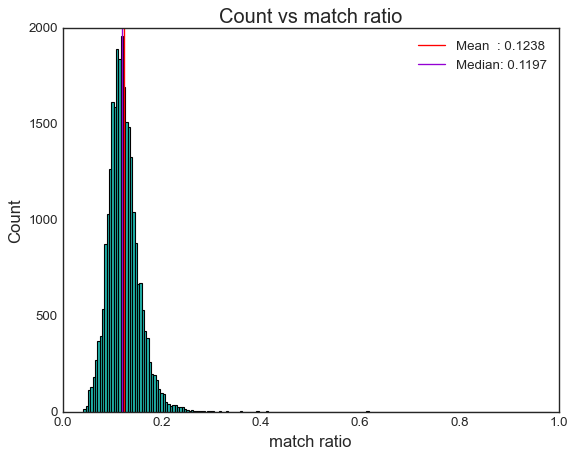

In [10]:
_ = gpcr.hist_quick( optimal_match_ratios_overall_gpcr_df["match_ratio_overall"],
                     bins        = 200,
                     label_xaxis = "match ratio" )

In [11]:
# gpcr.GPCR_DF

Total count: 26299
Nan count:   0
Hist Count:  26299
Min:         0.041916167664670656
Mean:        0.1238
Median:      0.1197
Max:         0.9850746268656716
Skew:        4.974505157949907
kurtosis:    71.97580015201139


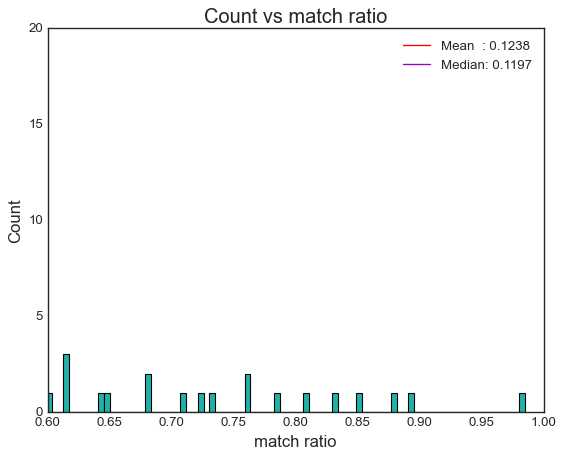

In [12]:
_ = gpcr.hist_quick( optimal_match_ratios_overall_gpcr_df["match_ratio_overall"],
                     bins = 200,
                     xlim = (0.6, 1), ylim = (0,20),
                     label_xaxis = "match ratio" )

### Following is the removed sequences from DisProt

In [13]:
removed_dataset_gpcr_df

,index_seq_1,index_seq_2,start_seq_1,start_seq_2,match,mismatch,length_comparision,length_non_comparision,match_ratio_comparision_length,match_ratio_overall,seq_1,seq_2
66,224,225,0,0,66,1,67,0,0.985075,0.985075,SSGFQADFHELLRRLCGLWGQWQQESSMELKEQKGGEEQRADRPAE...,SSGFQADFHELLRRLCGLWGQWQQESSMELKEQKGGEEQRADRPAE...


### Now that we have our reduced dataset, we can now use it to plot hydrophobicity

# <span style="color:red"> Hydrophobicity with reduced dataset </span>

# <span style="color:orange"> Hydrophobicity in reduced GPCR at ph = 2 </span>

100% |########################################################################|


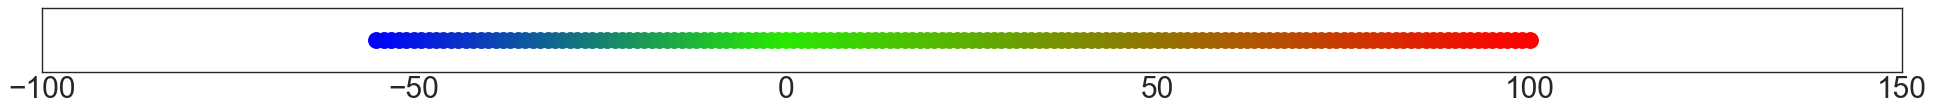

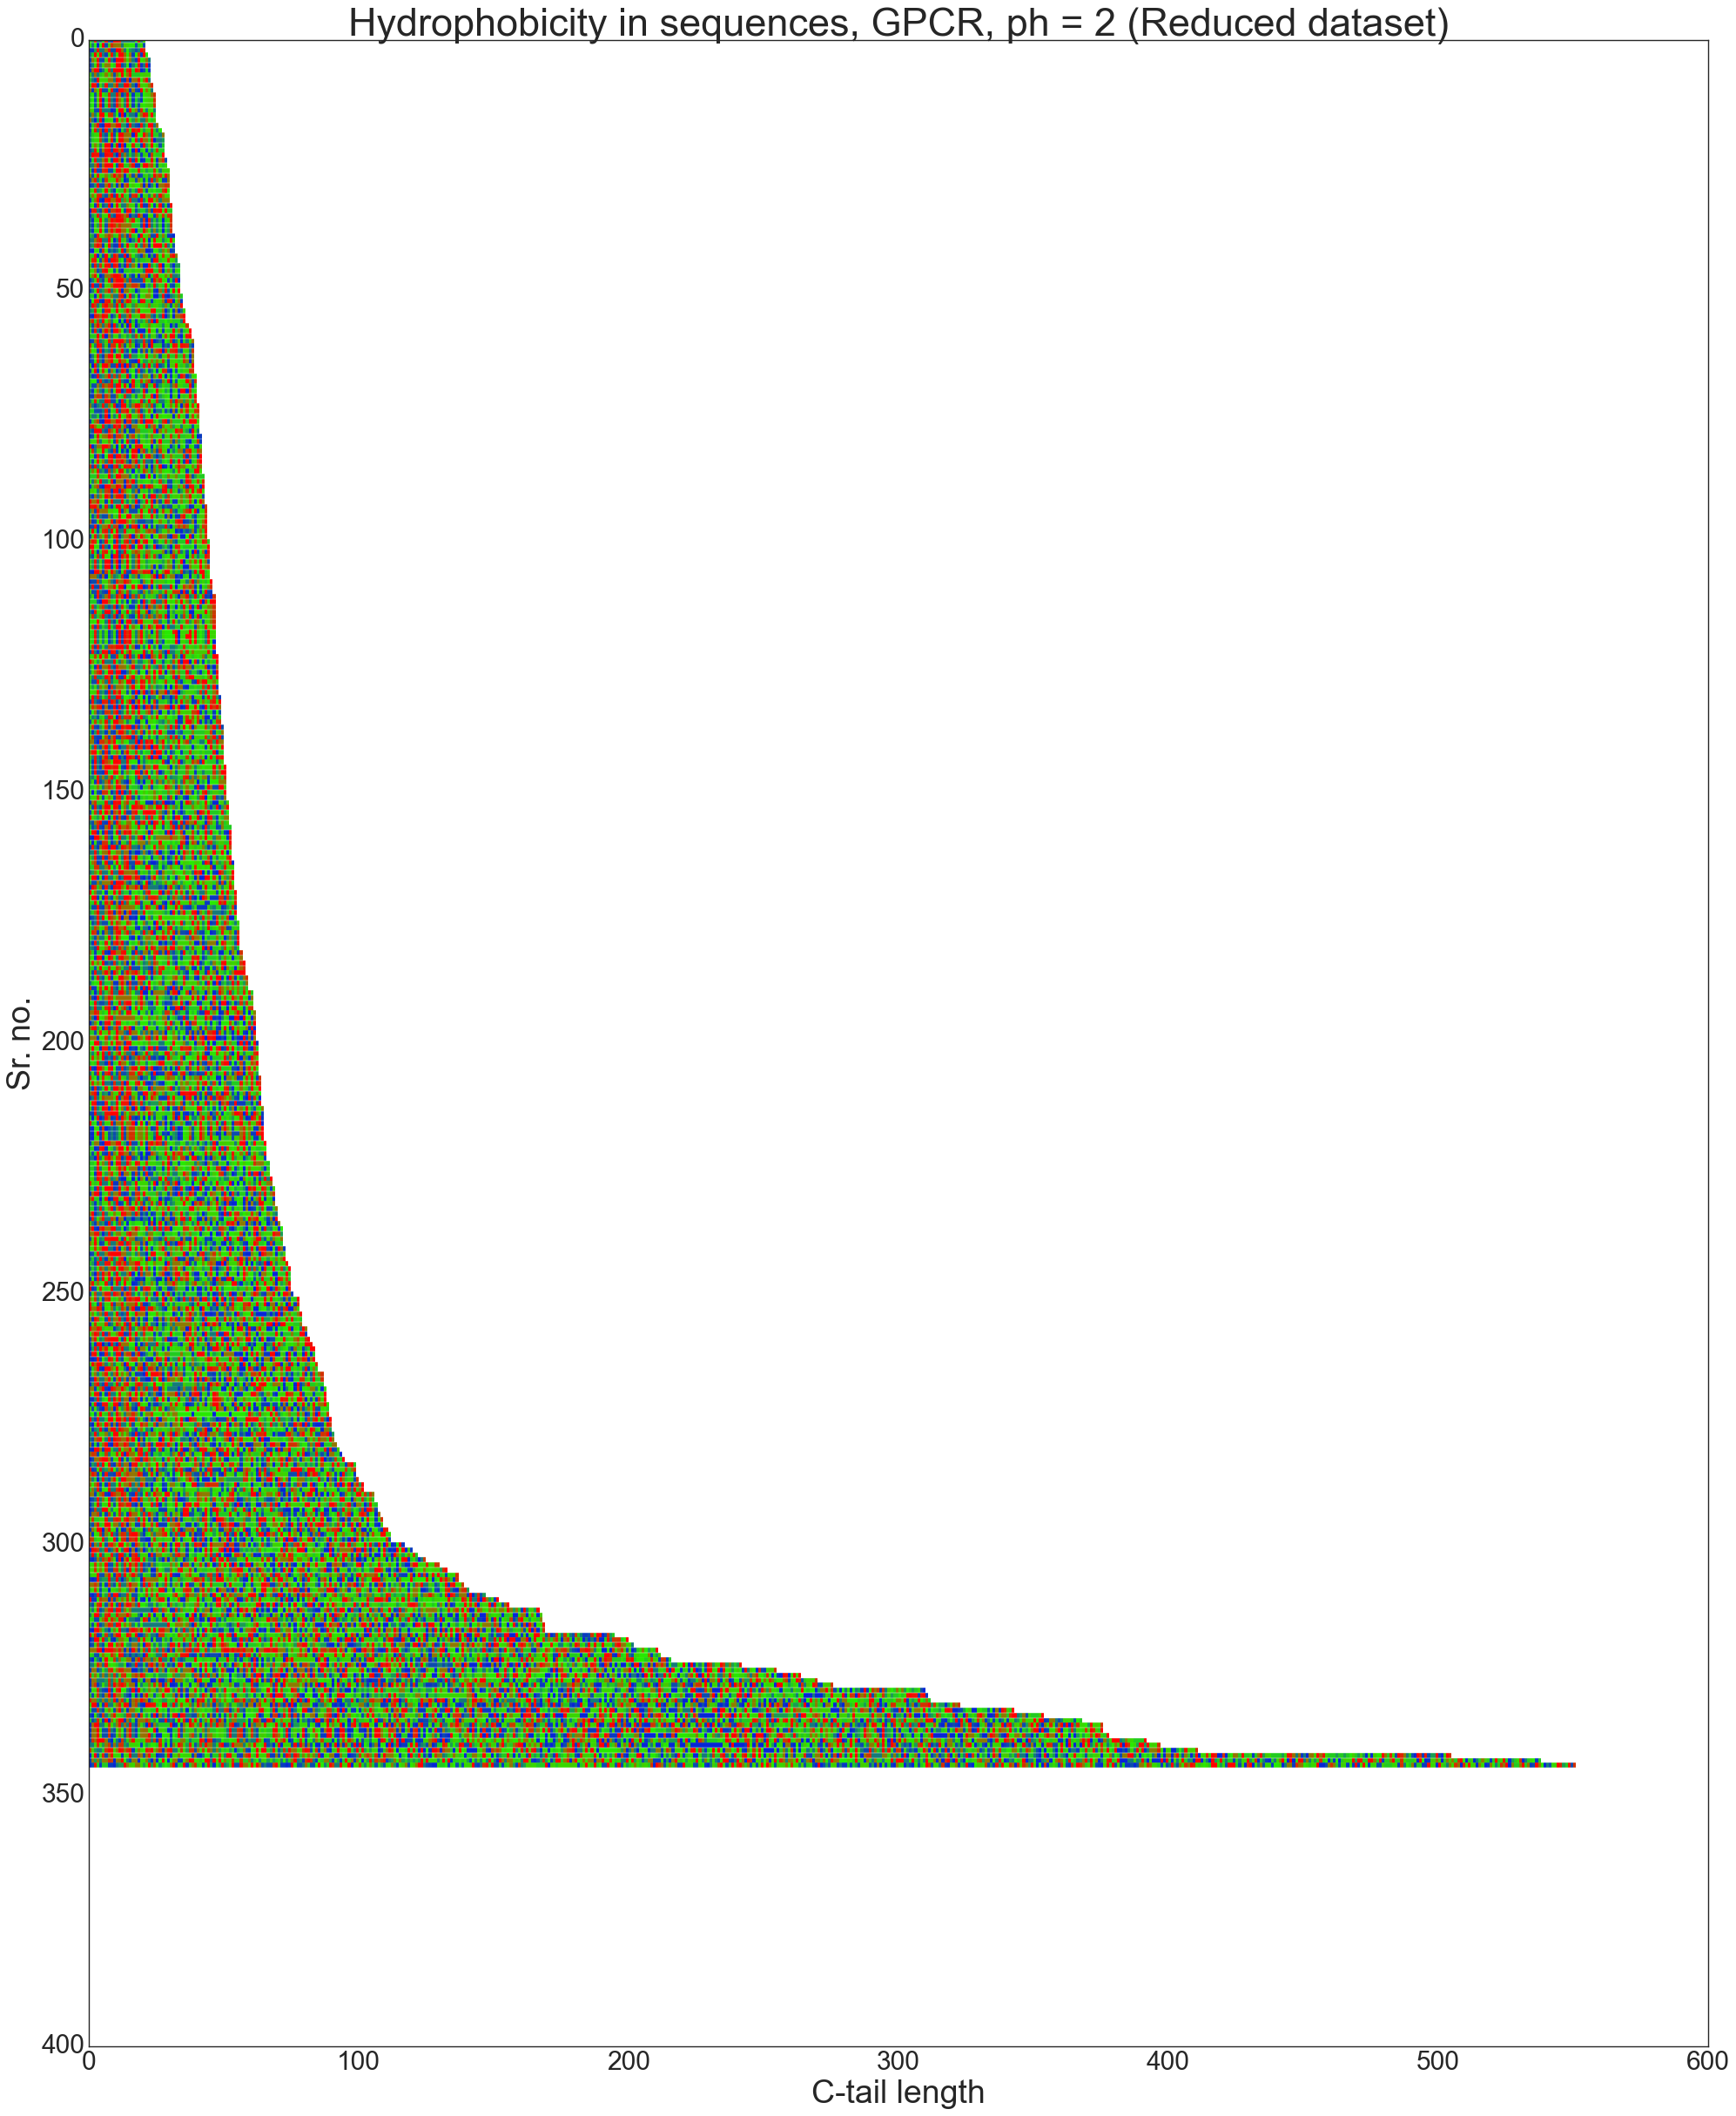

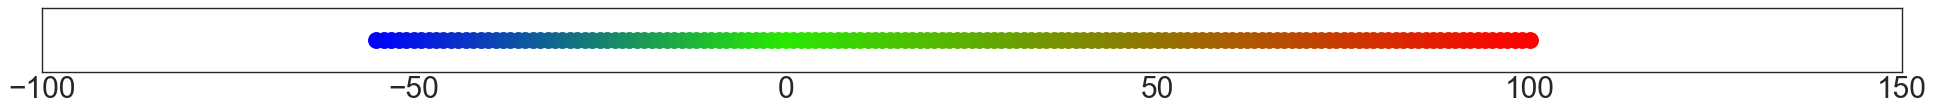

In [18]:
_ = gpcr.line_hydrophobicity_in_sequences( df           = reduced_dataset_gpcr_df,
                                           scale_factor = 0.45,
                                           figsize      = (30, 36),
                                           dataset      = "GPCR",
                                           ylim         = (400, 0),
                                           title_add    = ", ph = 2 (Reduced dataset)" ) 

In [ ]:
_ = gpcr.line_hydrophobicity_in_sequences( df           = reduced_dataset_gpcr_df,
                                           scale_factor = 0.45,
                                           figsize      = (30, 36),
                                           dataset      = "GPCR",
                                           ylim         = (400, 0),
                                           title_add    = ", ph = 2 (Reduced dataset)" ) 

In [ ]:
_ = gpcr.line_hydrophobicity_in_sequences( df           = reduced_dataset_gpcr_df,
                                           scale_factor = 0.45,
                                           figsize      = (30, 36),
                                           dataset      = "GPCR",
                                           ylim         = (400, 0),
                                           title_add    = ", ph = 2 (Reduced dataset)" ) 

# <span style="color:orange"> Hydrophobicity in reduced DisProt at ph = 2 </span>

### Lets reduce DisProt dataset with `limit_match_score   = 0.9`

In [19]:
reduced_dataset_disprot_df, removed_dataset_disprot_df, optimal_match_ratios_overall_disprot_df, disprot_df = gpcr.reduce_dataset_based_on_match_ratio( 
                                                                                                                df                  = gpcr.DISPROT_DF,
                                                                                                                sequences           = (),
                                                                                                                limit_match_score   = 0.9,
                                                                                                                show_details        = True )

100% |########################################################################|


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                    Matched sequences
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Seq 0     (aa_loc = 0    - 17  ) :   GTRIIYDRKFLMECRNSPVT
Seq 6     (aa_loc = 2    - 19  ) : PGGTRIIYDRKFLMECRNSP
Match                            : 18
Mis-match                        : 0
Comparision length               : 18
Non comparision length           : 4
Comparision length match-ratio   : 1.0000000000     [ Comparision length match-ratio =  Match  /  Comparision length
Overall length match-ratio       : 0.9000000000     [ Overall length match-ra

### Following is the removed sequences from DisProt

Remember that before performing this reduction based on match-ratio we have already removed sequences with length greater than 600 so the dataset was aleardy reduced a little bit

In [20]:
removed_dataset_disprot_df

,index_seq_1,index_seq_2,start_seq_1,start_seq_2,match,mismatch,length_comparision,length_non_comparision,match_ratio_comparision_length,match_ratio_overall,seq_1,seq_2
17,0,6,0,2,18,0,18,4,1.00,0.900000,GTRIIYDRKFLMECRNSPVT,PGGTRIIYDRKFLMECRNSP
19,7,49,0,1,20,0,20,1,1.00,0.975610,SHLKSKKGQSTSRHKKLMFK,SSHLKSKKGQSTSRHKKLMFK
20,15,44,0,0,20,0,20,1,1.00,0.975610,SKTSKVRPSTGNSASTPQSQ,SKTSKVRPSTGNSASTPQSQC
20,16,41,0,0,20,0,20,1,1.00,0.975610,MATTATMATSGSARKRLLKE,MATTATMATSGSARKRLLKEE
0,49,68,1,0,20,0,20,3,1.00,0.930233,SSHLKSKKGQSTSRHKKLMFK,SHLKSKKGQSTSRHKKLMFKTE
25,125,171,0,1,25,0,25,2,1.00,0.961538,GATAFPADSDRHCNGFPAGAEVTNR,AGATAFPADSDRHCNGFPAGAEVTNRP
26,130,178,0,0,25,0,25,2,1.00,0.961538,MPVAGSELPRRPLPPAAQERDAEPR,MPVAGSELPRRPLPPAAQERDAEPRPP
25,147,165,0,1,26,0,26,1,1.00,0.981132,AKWDTANNPLYKEATSTFTNITYRGT,RAKWDTANNPLYKEATSTFTNITYRGT
23,153,154,0,2,24,0,24,4,1.00,0.923077,KVAKVSQGVEDGPDTKRAKLDSSETT,KTKVAKVSQGVEDGPDTKRAKLDSSE
26,180,204,0,3,27,0,27,3,1.00,0.947368,SKRIPYAPSGEIPKFSLQDPPNKKPKV,KVSSKRIPYAPSGEIPKFSLQDPPNKKPKV


### From above, 59 pairs got macthed with Overall length match-ratio > 0.9

In [21]:
print( len( disprot_df ) )
print( len( reduced_dataset_disprot_df ) )

818
761


100% |########################################################################|


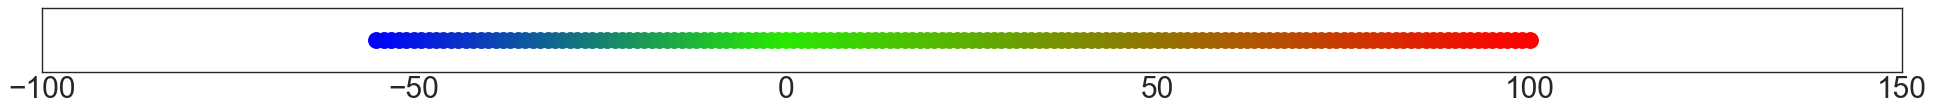

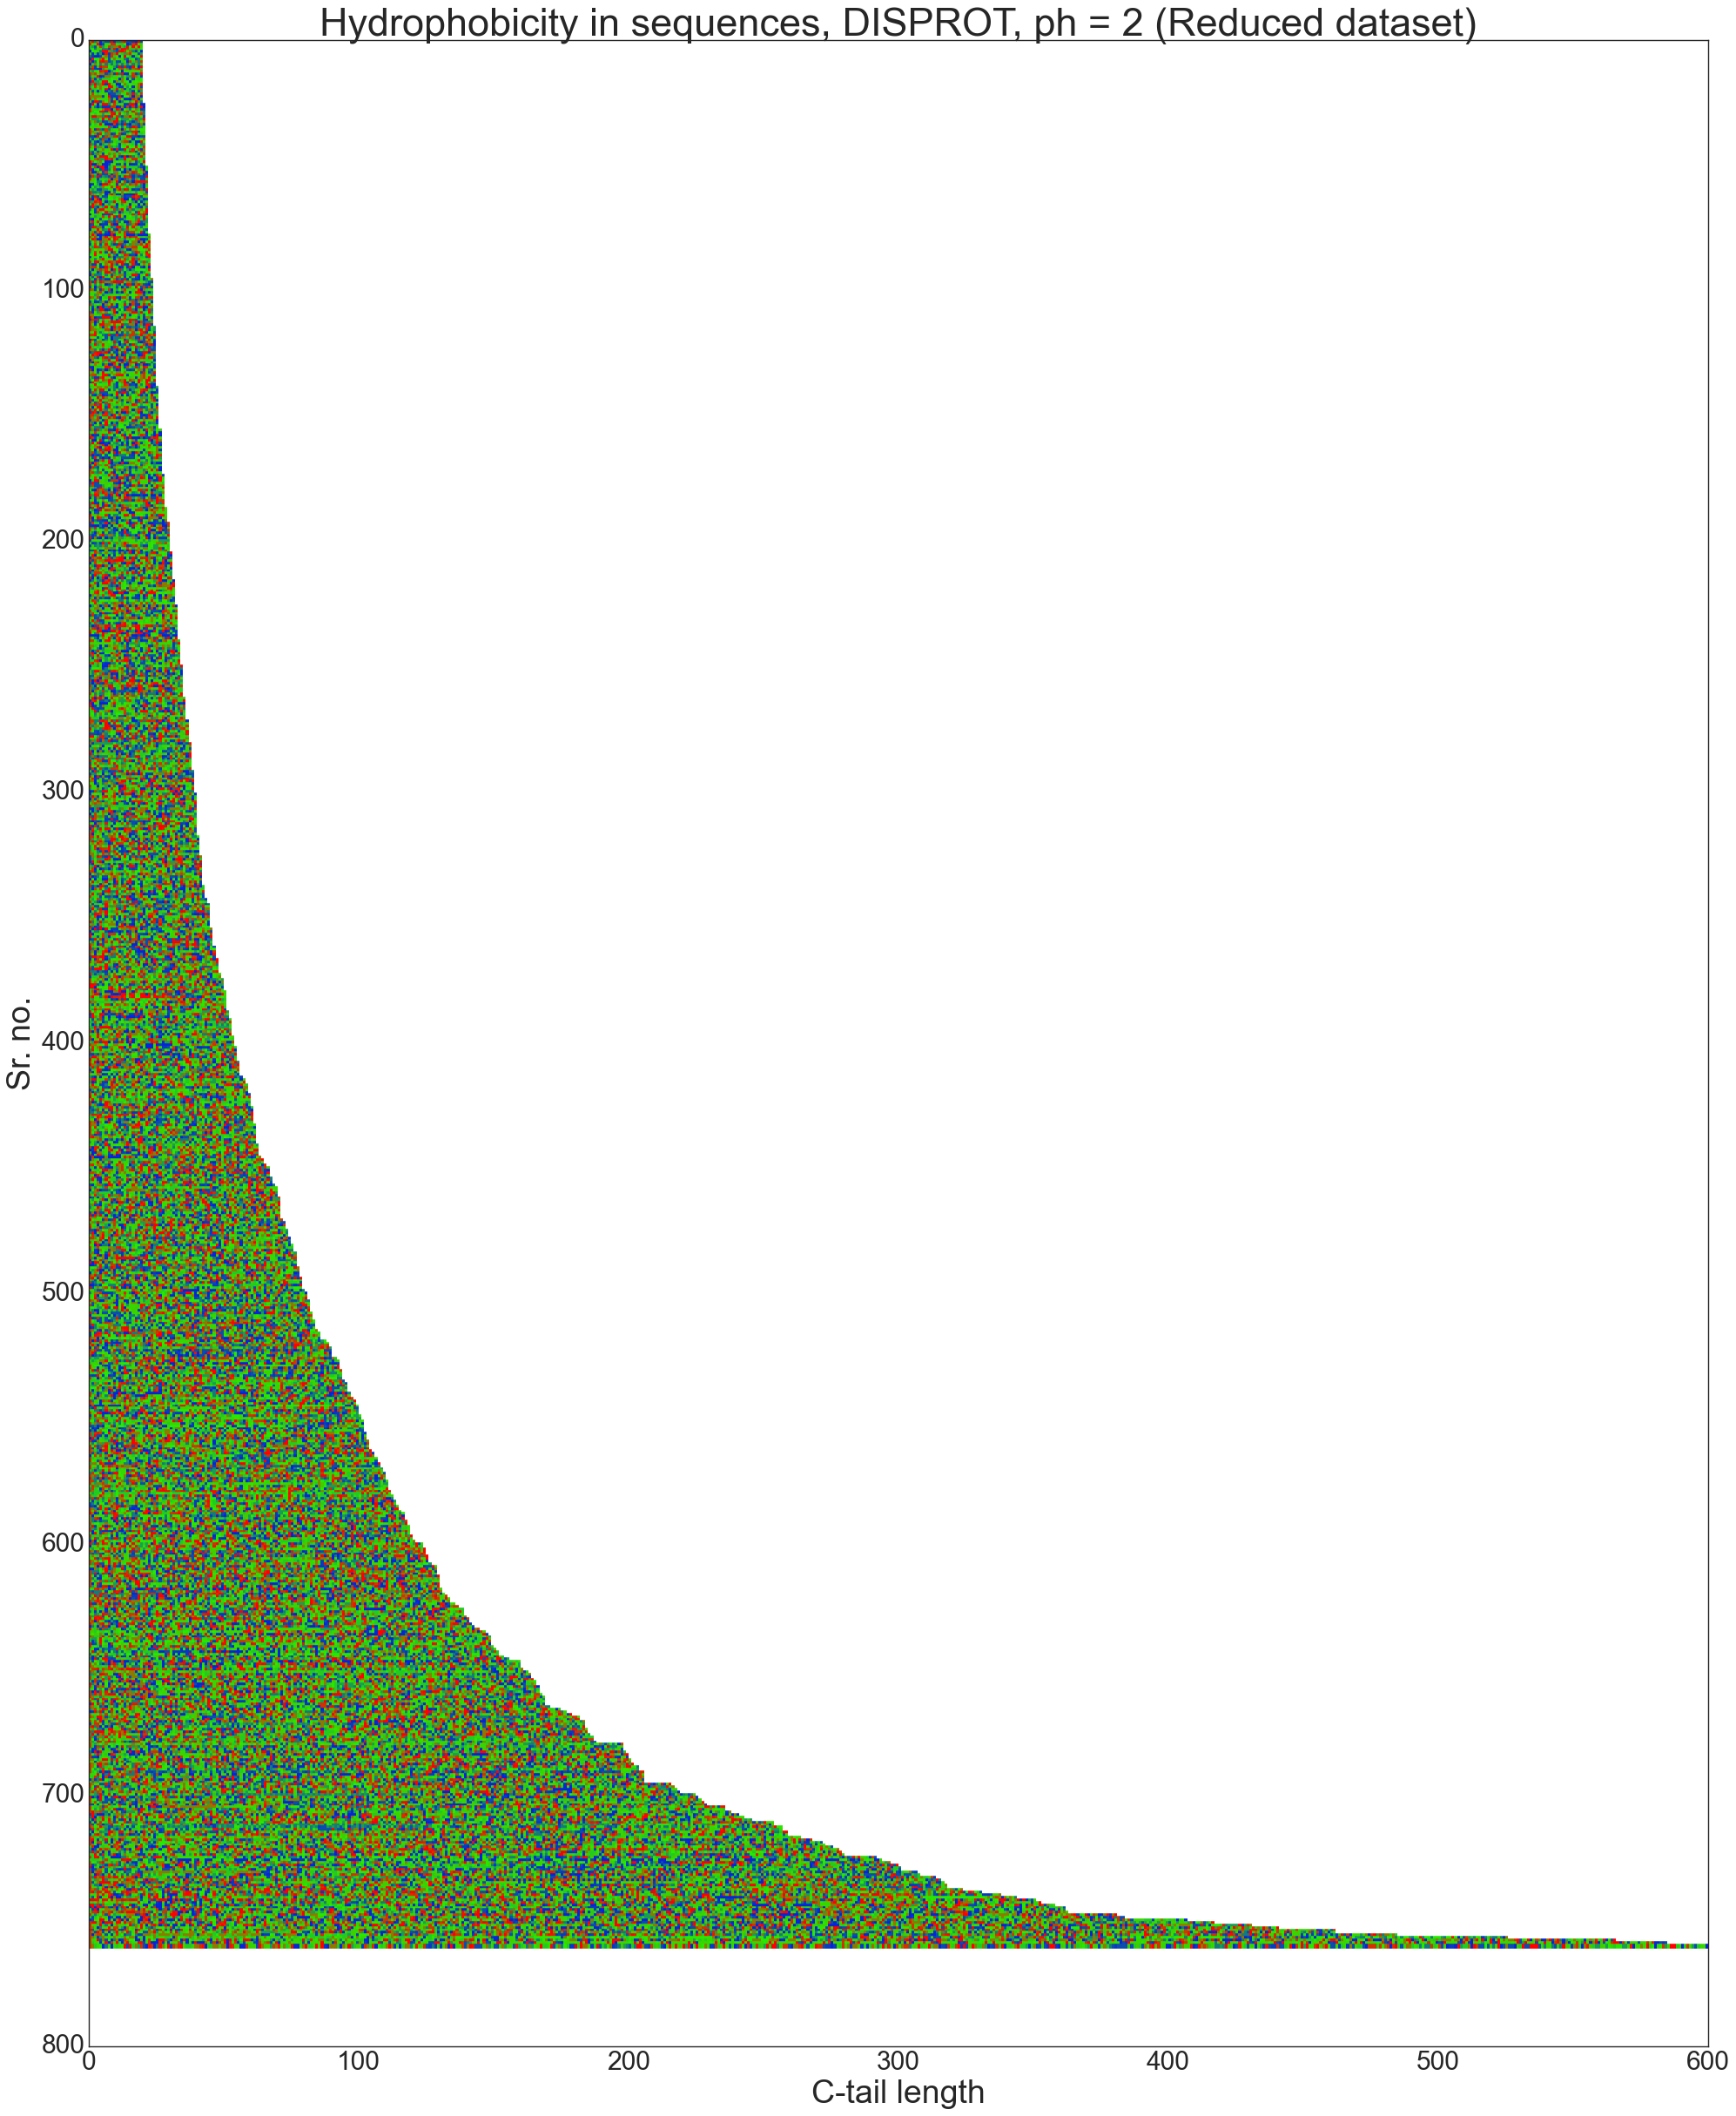

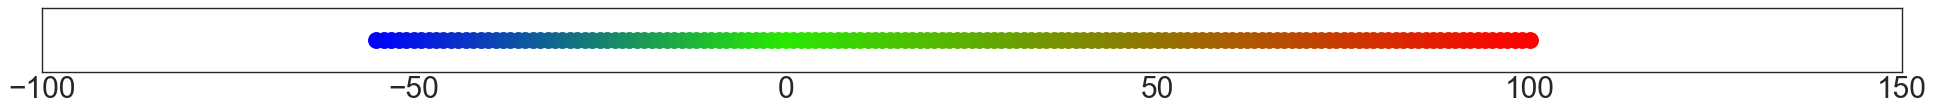

In [22]:
_ = gpcr.line_hydrophobicity_in_sequences( df           = reduced_dataset_disprot_df,
                                           scale_factor = 0.45,
                                           figsize      = (30, 36),
                                           dataset      = "DISPROT",
                                           title_add    = ", ph = 2 (Reduced dataset)" ) 

# <span style="color:orange"> My thoughts </span>

### <span style="color:skyblue"> On the new methods </span>
- Even though this new method has reduced the GPCR dataset by just 1, this is not because of the inefficiency of the method but because of the nature of dataset. We do not have many similar sequences in GPCR dataset. But, it ensures that we have removed similar sequences.  
- For DisProt dataset, 59 sequences got removed.

### <span style="color:skyblue"> On the hydrophobicity plot </span>
- From the plot for GPCR, we can see that the beginning for each sequence is hydrophobic (red) and that is because that part is close to the transmembrane-helix-7 (TM7).  
- If we want to compare GPCR with DisProt or any other dataset, I think we should not take that initial hydrophobic(red) part into consideration.

# <span style="color:orange"> Currently working on </span>

### <span style="color:skyblue"> 1. Trying to find some pattern in the hydrophobicity plot </span>
I see some little continuous red patches and blue patches, trying to look for a code and to understand what it means.

### <span style="color:skyblue"> 2. Locating phosphorylation sites </span>
I am reading about locating phosphorylation sites on the internet.  
Please help me with this.

### <span style="color:green"> ⭐ Please suggest other tasks or any other approach </span>